In [1]:
import numpy as np
import pandas as pd
import mne
import scipy.stats as sp_stats
import scipy.signal as sp_sig
import antropy as ant
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import robust_scale
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold
from scalp_utils import get_metrics, run_all, run_specific_chan
import joblib
import seaborn as sns
from IPython.display import clear_output

plt.style.use('dark_background')
pd.options.display.precision = 10

In [2]:
sr = 1000

In [3]:
# run only AH
X_train, X_test, y_train, y_test = run_specific_chan('AH')
clear_output()

In [4]:
# try fix leak
X_train, X_test, y_train, y_test = run_all()
clear_output()

In [5]:
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

In [33]:
X_train_data.columns.shape

(43,)

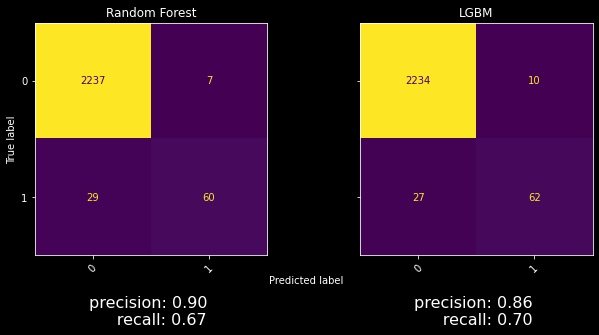

In [6]:
# overlapping
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-60, -40), textcoords='offset points',
                ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        y_lgbm = y_pred
    else:
        y_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


# f.colorbar(disp.im_, ax=axes)
plt.show()

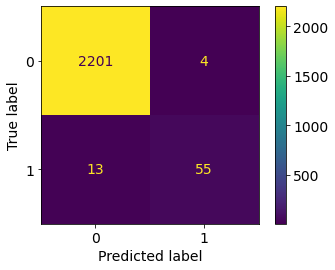

In [36]:
# overlapping
cf_matrix = confusion_matrix(y_lgbm, y_rf)
metrics = get_metrics(cf_matrix)
disp = ConfusionMatrixDisplay(cf_matrix)
disp.plot()

In [65]:
# Leave one out test (each time remove other subj from list)
# ['396', '398', '402', '406', '415', '416']
x_AH, x_bi, x_A, feat_all, y_all = run_all_multi_channel_with_x_neighbor(subjects=['396', '398', '402', '406', '416'])
from IPython.display import clear_output
clear_output()

In [32]:
all_col = feat_all.columns
X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

In [50]:
[i for i, x in enumerate(y_rf) if x == y_lgbm[i] and x != y_test[i] and y_test[i] == 0]

[1269, 1426, 1760]

In [48]:
import lightgbm
lightgbm.plot_importance()

1.0

In [36]:
# i_pred = [i for i, x in enumerate(y_rf) if x == y_lgbm[i] and x != y_test[i] and y_test[i] == 1]
i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
for i in i_pred:
    fig, axs = plt.subplots(3)
    axs[0].set_title(i)
    pred_view = np.concatenate(x_AH[i - 4: i + 5])
    axs[0].plot(pred_view)
    axs[0].plot(range(1000, 1250), x_AH[i], c='red')
    # pred_view = np.concatenate(x_A[i - 4: i + 5])
    # axs[1].plot(pred_view)
    # axs[1].plot(range(1000, 1250), x_A[i], c='green')
    # pred_view = np.concatenate(x_bi[i - 4: i + 5])
    # axs[2].plot(pred_view)
    # axs[2].plot(range(1000, 1250), x_bi[i], c='pink')

KeyError: 'epoch'

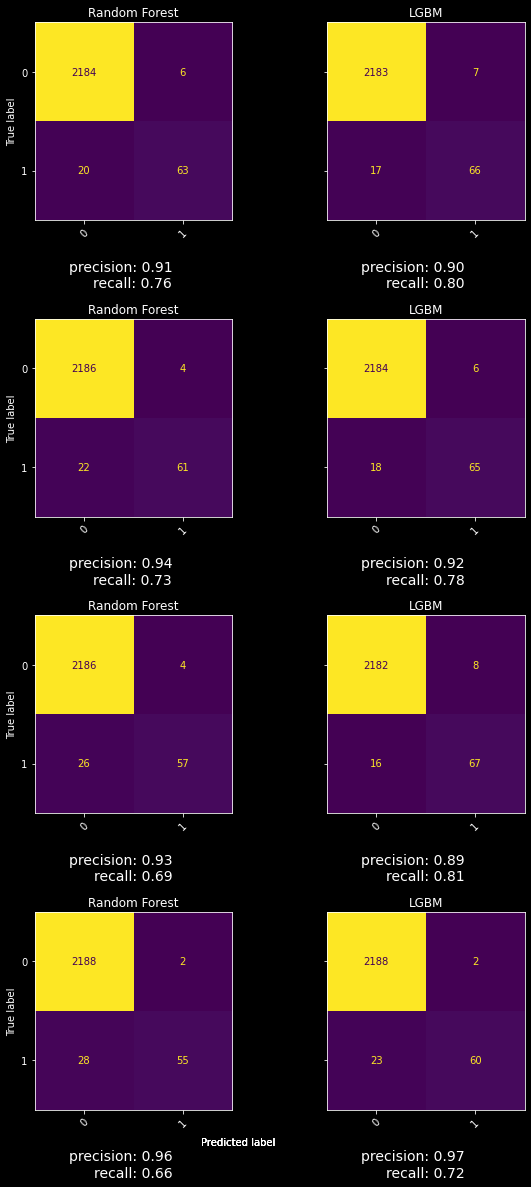

Random forest precision: 0.9377108817330897
Random forest recall: 0.7108433734939759
LGBM precision: 0.9201694539011948
LGBM recall: 0.7771084337349399


In [23]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=4, test_size=0.25, random_state=None)
# skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=None)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier()
}
f, axes = plt.subplots(4, len(classifiers), figsize=(10, 20), sharey='row')
feat_all_np = feat_all.to_numpy()
precision_list = []
recall_list = []
for j, (train_index, test_index) in enumerate(skf.split(feat_all, y_all)):
    X_train, X_test = feat_all.iloc[train_index], feat_all.iloc[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]
    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[j][i], xticks_rotation=45)
        text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
        axes[j][i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=14,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        precision_list.append(metrics['precision'])
        recall_list.append(metrics['recall'])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

precision_list_np = np.array(precision_list)
recall_list_np = np.array(recall_list)
plt.show()
rf_precision = np.sum(precision_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_precision = np.sum(precision_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
rf_recall = np.sum(recall_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_recall = np.sum(recall_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
print("Random forest precision: {}".format(rf_precision))
print("Random forest recall: {}".format(rf_recall))
print("LGBM precision: {}".format(lgbm_precision))
print("LGBM recall: {}".format(lgbm_recall))

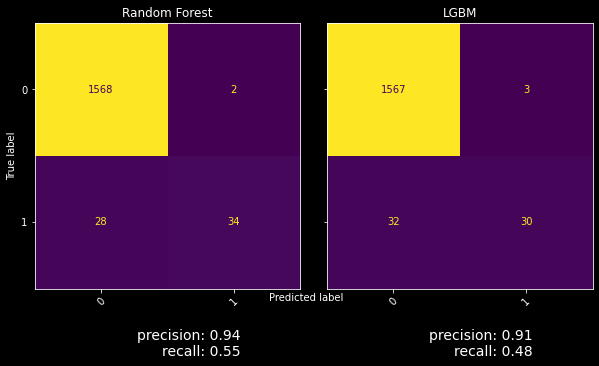

In [69]:
# check metrics for leave one out test
x_AH_396, x_bi_396, x_A_396, feat_396, y_396 = run_all_multi_channel_with_x_neighbor(subjects=['415'])
clear_output()
# all_col = feat_all.columns
# X_train, X_test, y_train, y_test = train_test_split(feat_all, y_all, stratify=y_all, random_state=20)
feat_396_data = feat_396.iloc[:, 2:]
feat_396_data = feat_396_data[X_train_data.columns]
# X_test_data = X_test[X_train_data.columns]
f, axes = plt.subplots(1, len(classifiers), figsize=(10, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.predict(feat_396_data)
    cf_matrix = confusion_matrix(y_396, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
                  recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=14,
                        xytext=(-60, -40), textcoords='offset points',
                        ha='right', va='top')
    # precision_list.append(metrics['precision'])
    # recall_list.append(metrics['recall'])
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.1, hspace=0.5)

In [11]:
# # all tags (for qa)
# i_all = feat_all[y_all == 1].sort_values(by='epoch').index.tolist()
# for i in i_all:
#     plt.figure()
#     plt.title(i)
#     pred_view = np.concatenate(x_all[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(1000, 1250), x_all[i], c='fuchsia')

In [ ]:
# i_train = X_train[y_train == 1].sort_values(by='epoch').index.tolist()
# for i in i_train:
#     plt.figure()
#     plt.title(i)
#     pred_view = np.concatenate(x_all[i - 4: i + 5])
#     plt.plot(pred_view)
#     plt.plot(range(1000, 1250), x_all[i], c='yellowgreen')

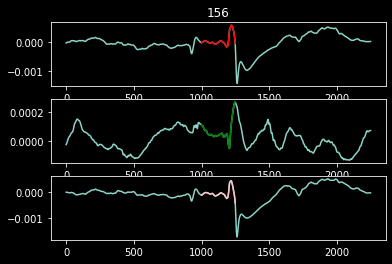

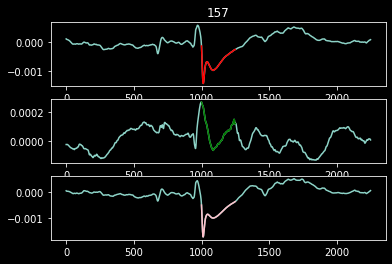

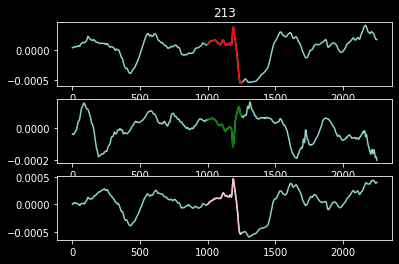

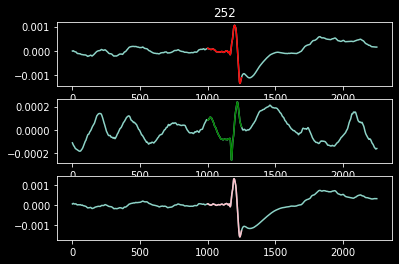

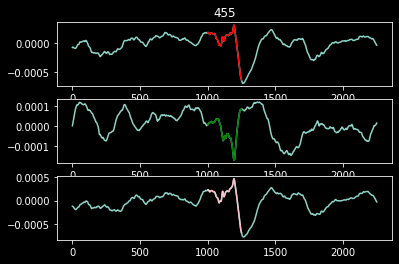

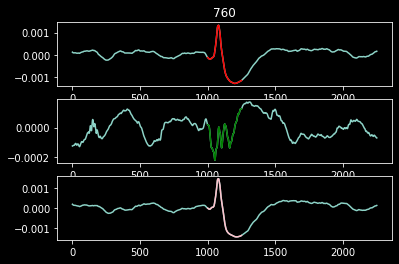

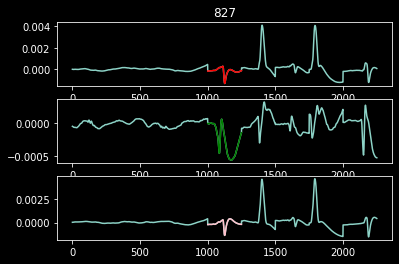

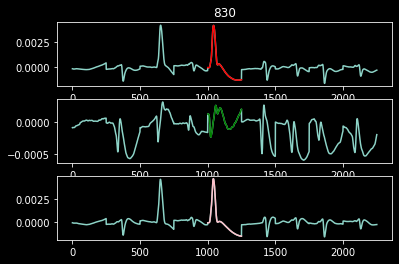

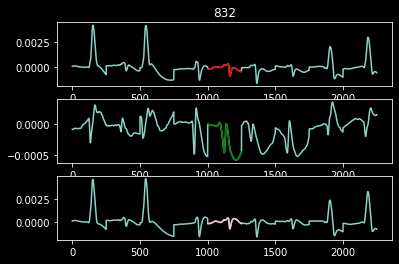

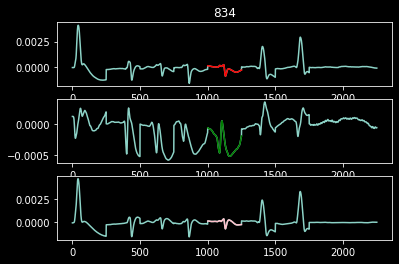

In [64]:
i_pred = X_test[y_pred == 1].sort_values(by='epoch').index.tolist()
for i in i_pred[:10]:
    fig, axs = plt.subplots(3)
    axs[0].set_title(i)
    pred_view = np.concatenate(x_AH[i - 4: i + 5])
    axs[0].plot(pred_view)
    axs[0].plot(range(1000, 1250), x_AH[i], c='red')
    pred_view = np.concatenate(x_A[i - 4: i + 5])
    axs[1].plot(pred_view)
    axs[1].plot(range(1000, 1250), x_A[i], c='green')
    pred_view = np.concatenate(x_bi[i - 4: i + 5])
    axs[2].plot(pred_view)
    axs[2].plot(range(1000, 1250), x_bi[i], c='pink')

In [27]:
# save model to file
# model_file = 'lgbm_model_multichannel.pkl'
# joblib.dump(classifiers['LGBM'], model_file)

model_file = 'lgbm_full_no_leak.pkl'
feat = pd.concat([X_train, X_test.iloc[:, 2:]]).iloc[:, 2:]
# feat = feat_all.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(feat)
feat_data = feat[feat.columns[selector.get_support(indices=True)]]
all_data_lgbm = LGBMClassifier().fit(feat_data, y_all)
joblib.dump(all_data_lgbm, model_file)

# joblib.dump(classifiers['Random Forest'], model_file)

In [41]:
model_file = 'lgbm_AH_only_7.pkl'
# feat = pd.concat([X_train, X_test.iloc[:, 2:]]).iloc[:, 2:]
feat = feat_all.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(feat)
feat_data = feat[feat.columns[selector.get_support(indices=True)]]
all_data_lgbm = LGBMClassifier().fit(feat_data, y_all)
joblib.dump(all_data_lgbm, model_file)

['lgbm_AH_only_7.pkl']

In [42]:
cols_df = feat_data.drop(feat_data[:].index)
cols_df.to_csv('features_AH_only_7.csv')
cols_df.shape

(0, 42)

In [9]:
joblib.dump(X_test_data, 'depth_x_test_data.pkl')
joblib.dump(y_test, 'depth_y_test.pkl')

['depth_y_test.pkl']

In [66]:
cols_df = feat_all.drop(feat_all[:].index)
cols_df.to_csv('features_forest.csv')

In [75]:
feat_y = feat_all
feat_y['y'] = y_all
cor = feat_y.corr()
cor

,skew,kurt,nzc,hcomp,at,gt,ag,af,std_cmin_norm,iqr_cmin_norm,...,A1_gamma_pmin_norm,A1_fast_pmin_norm,A1_at_pmin_norm,A1_gt_pmin_norm,A1_ft_pmin_norm,A1_ag_pmin_norm,A1_af_pmin_norm,A1_abspow_pmin_norm,A1_perm_pmin_norm,y
skew,1.0000000000,0.0083287505,0.0208829328,0.0032197219,-0.0093967990,-0.0130105296,-0.0346816804,-0.0114458667,0.0404509879,0.0078351054,...,0.0077117861,0.0158607000,0.0009552196,-0.0071435452,0.0006575161,-0.0039209564,0.0041198445,0.0511226047,-0.0108018231,0.0445046244
kurt,0.0083287505,1.0000000000,0.1041042500,-0.2322130759,0.1920543456,0.1288938784,0.1070287068,0.0312198922,0.0653720465,-0.1357007555,...,0.0804232172,0.0400882475,0.0965420795,0.0424393052,0.0361578042,0.0226563810,0.0097868654,0.1010853493,-0.0121027098,0.2539404864
nzc,0.0208829328,0.1041042500,1.0000000000,-0.1296998899,0.1744604365,0.1586971116,0.1273146672,0.0954538923,-0.1067519629,-0.1300015838,...,0.1030990937,0.0609969367,0.0815229167,0.0737704993,0.0596577515,0.0456770056,0.0280376099,-0.0147537223,0.0851166466,0.0083541986
hcomp,0.0032197219,-0.2322130759,-0.1296998899,1.0000000000,-0.2085974314,-0.1122170815,-0.0754750797,-0.0160150006,0.1878037533,0.2895093437,...,-0.1478315111,-0.1039056176,-0.1668311674,-0.0799339072,-0.0836467736,-0.0494608651,-0.0405727201,-0.0181456216,-0.2132223436,-0.1249803087
at,-0.0093967990,0.1920543456,0.1744604365,-0.2085974314,1.0000000000,0.4211414417,-0.0034831380,-0.0065489122,-0.0742111132,-0.1257840782,...,0.0297680525,0.0150010296,0.2206657504,0.0296801321,0.0313172514,0.0044839090,-0.0006880652,0.0367684796,0.0434247221,0.0654354304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1_ag_pmin_norm,-0.0039209564,0.0226563810,0.0456770056,-0.0494608651,0.0044839090,0.1796335677,0.0802775094,0.0412891901,-0.0369426597,-0.0453304467,...,0.5161463977,0.3148705629,-0.0304801288,0.3984831827,0.3201099521,1.0000000000,0.8697521402,-0.0370292863,0.1081522753,-0.0120238887
A1_af_pmin_norm,0.0041198445,0.0097868654,0.0280376099,-0.0405727201,-0.0006880652,0.0455851976,0.0367736549,0.0315000099,-0.0535135226,-0.0572555281,...,0.3948161542,0.5186084109,-0.0423433563,0.2187205330,0.3710236802,0.8697521402,1.0000000000,-0.0446955501,0.1352341187,-0.0243021217
A1_abspow_pmin_norm,0.0511226047,0.1010853493,-0.0147537223,-0.0181456216,0.0367684796,-0.0115396581,-0.0250467095,-0.0138502870,0.5865961029,0.3975011724,...,-0.1049633946,-0.1162522309,0.0299679368,-0.0336394940,-0.0723983026,-0.0370292863,-0.0446955501,1.0000000000,-0.3336270893,0.4626939106
A1_perm_pmin_norm,-0.0108018231,-0.0121027098,0.0851166466,-0.2132223436,0.0434247221,0.0527796113,0.0545845839,0.0347948069,-0.3841532007,-0.3803349280,...,0.3139776028,0.3390395715,0.1002248815,0.1389301059,0.2247916849,0.1081522753,0.1352341187,-0.3336270893,1.0000000000,-0.2363257006


In [89]:
max_cor = cor[cor > 0.5]
max_cor = max_cor[max_cor.isnull().sum(axis=1) != max_cor.shape[0] - 1]
max_cor

,skew,kurt,nzc,hcomp,at,gt,ag,af,std_cmin_norm,iqr_cmin_norm,...,A1_gamma_pmin_norm,A1_fast_pmin_norm,A1_at_pmin_norm,A1_gt_pmin_norm,A1_ft_pmin_norm,A1_ag_pmin_norm,A1_af_pmin_norm,A1_abspow_pmin_norm,A1_perm_pmin_norm,y
kurt,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nzc,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcomp,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
at,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gt,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A1_ag_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5161463977,NaN,NaN,NaN,NaN,1.0000000000,0.8697521402,NaN,NaN,NaN
A1_af_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.5186084109,NaN,NaN,NaN,0.8697521402,1.0000000000,NaN,NaN,NaN
A1_abspow_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5865961029,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
A1_perm_pmin_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


<AxesSubplot:>

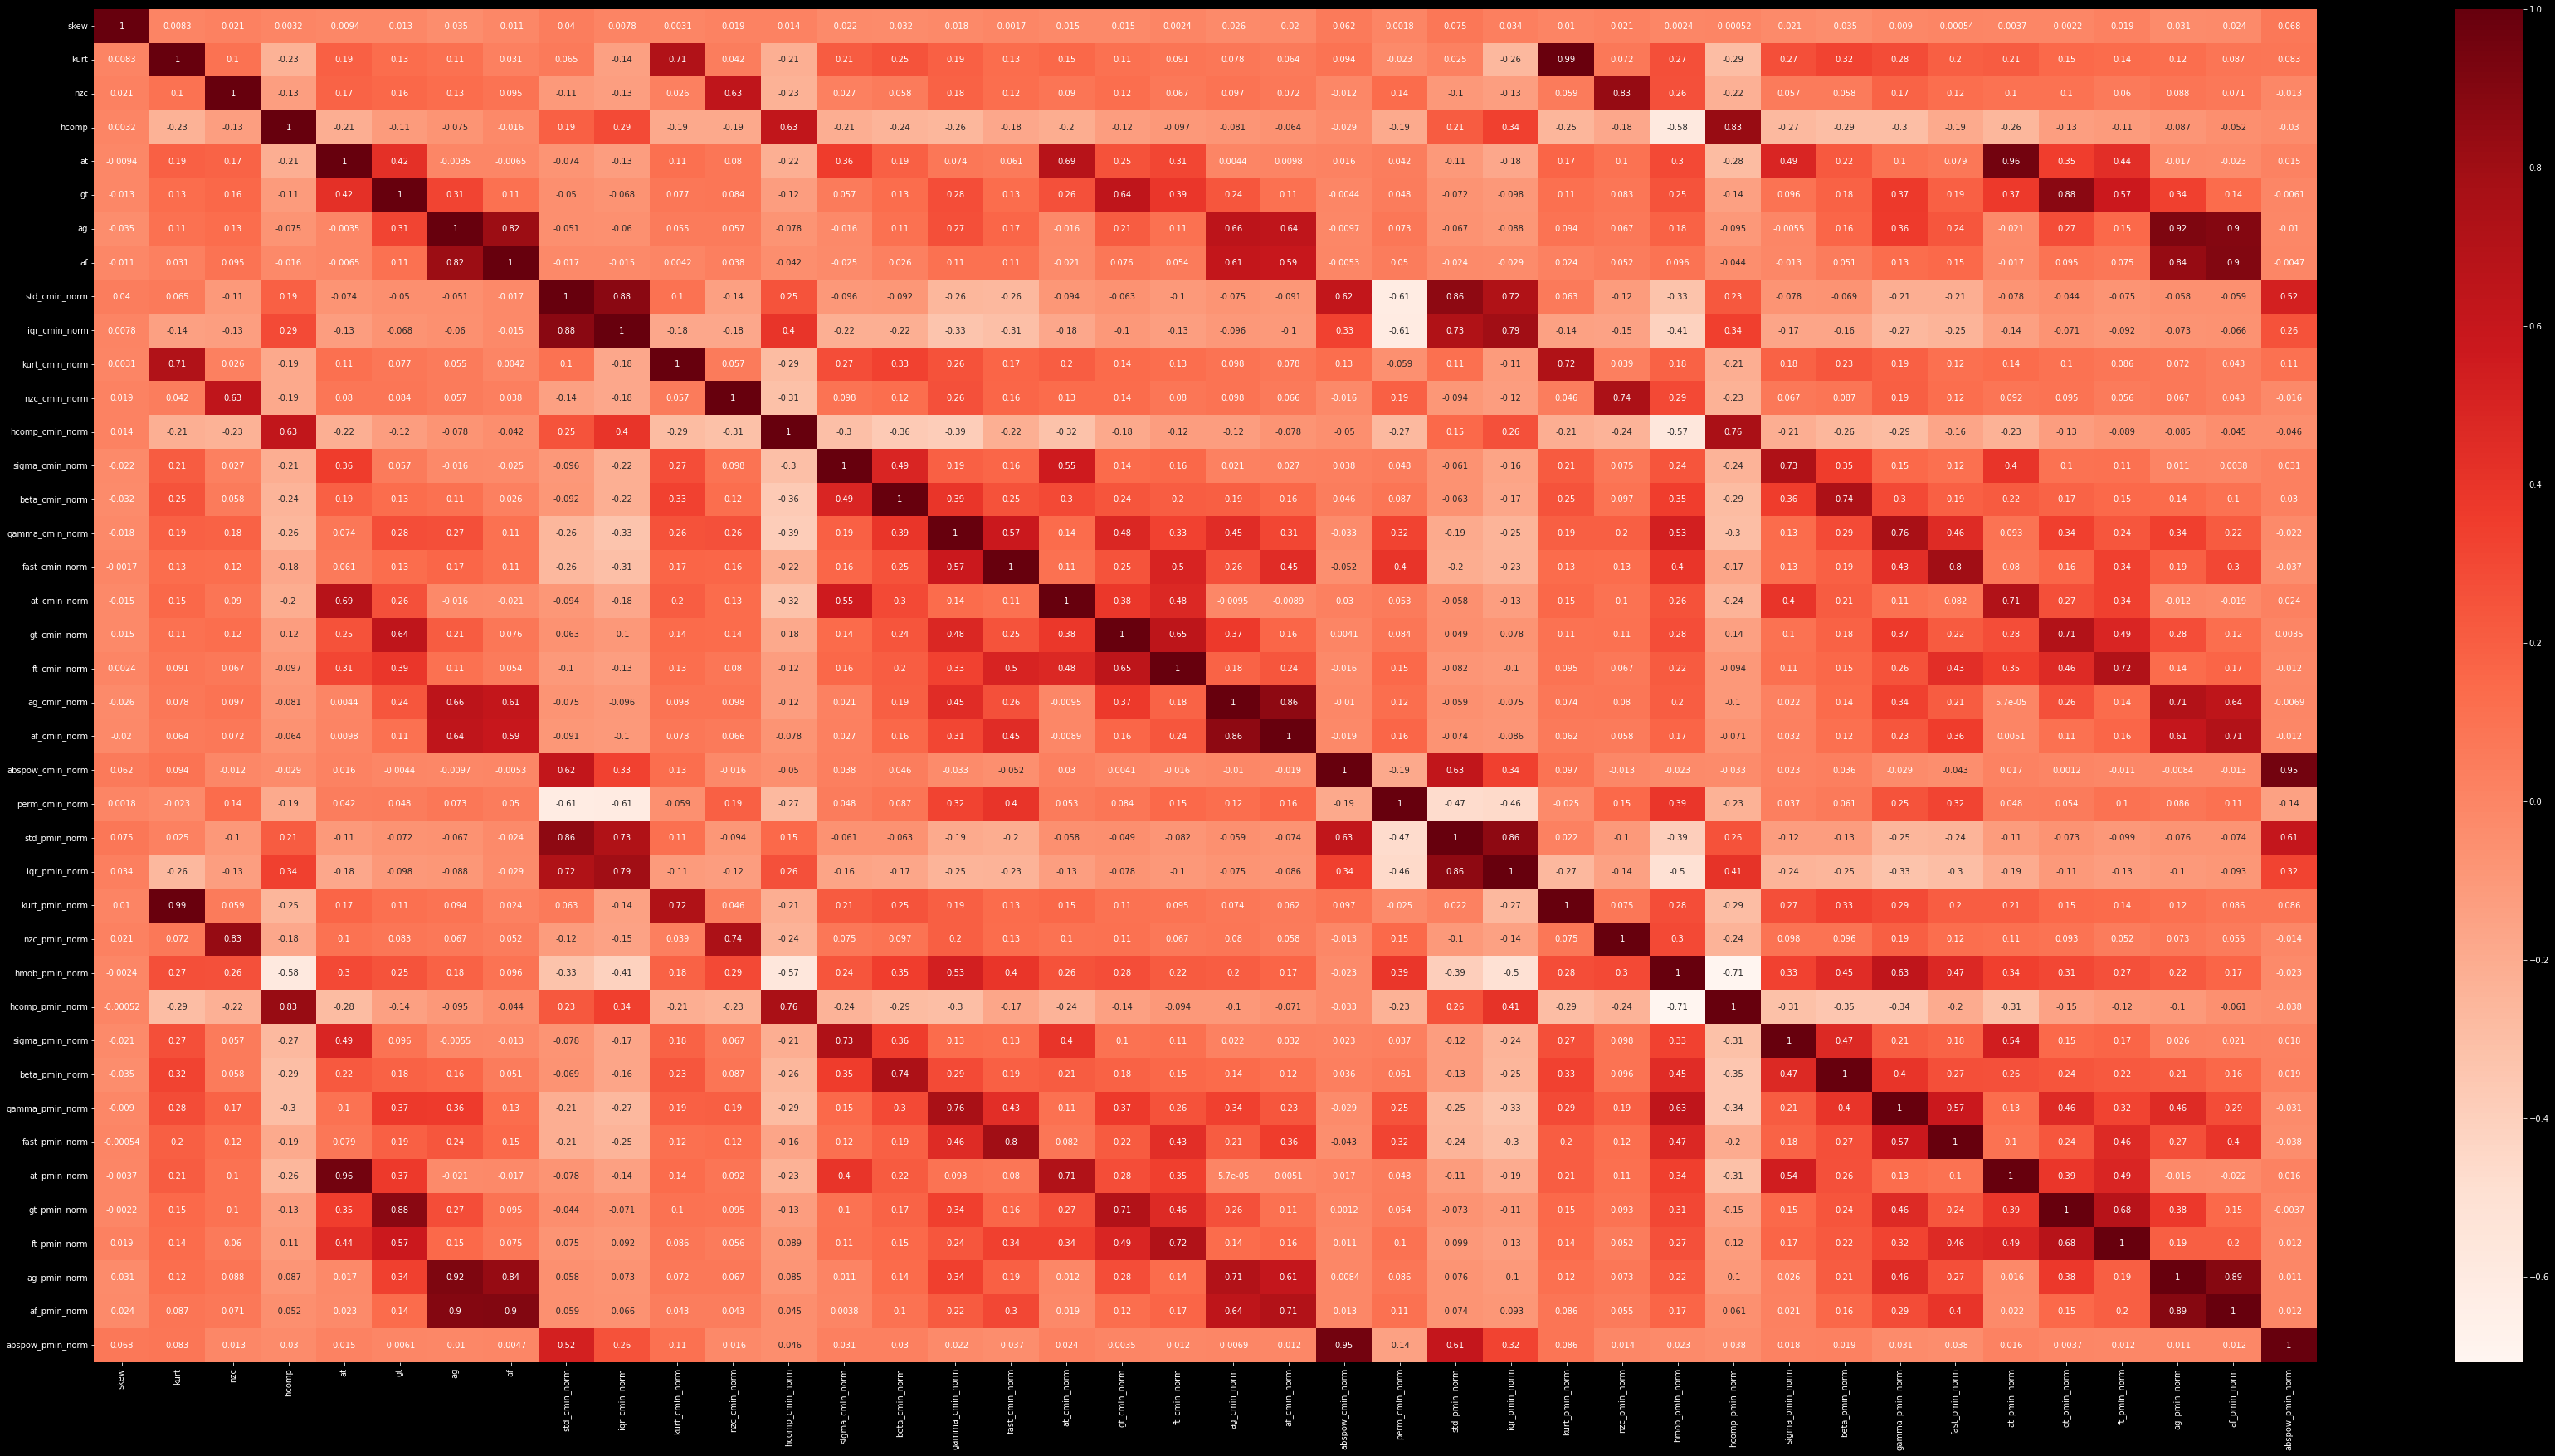

In [76]:
plt.rcParams['figure.figsize'] = (60, 30)
sns.heatmap(cor.iloc[:40, :40], annot=True, cmap=plt.cm.Reds)

<BarContainer object of 10 artists>

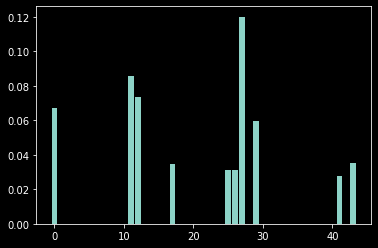

In [23]:
imp = pd.DataFrame(X_train_data.columns)
imp['imp'] = classifiers['Random Forest'].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(10)['imp'].values
plt.bar(imp.head(10).index, imp.head(10)['imp'].values)

In [24]:
imp.head(45)

,0,imp
27,abspow_cmin_norm,0.1201403544
11,abspow,0.0855913324
12,std_cmin_norm,0.0736665652
0,std,0.0669159773
29,std_pmin_norm,0.0594170740
43,abspow_pmin_norm,0.0351618267
17,hcomp_cmin_norm,0.0346983101
25,bf_cmin_norm,0.0313655018
26,gf_cmin_norm,0.0313549419
41,bf_pmin_norm,0.0277440190


<BarContainer object of 10 artists>

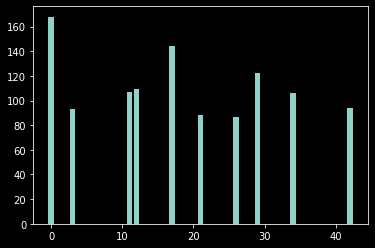

In [25]:
imp = pd.DataFrame(X_train_data.columns)
imp['imp'] = classifiers['LGBM'].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(10)['imp'].values
plt.bar(imp.head(10).index, imp.head(10)['imp'].values)

In [26]:
imp.head(45)

,0,imp
0,std,168
17,hcomp_cmin_norm,144
29,std_pmin_norm,122
12,std_cmin_norm,109
11,abspow,107
34,hcomp_pmin_norm,106
42,gf_pmin_norm,94
3,kurt,93
21,fast_cmin_norm,88
26,gf_cmin_norm,87


In [ ]:
random_metrics = []
for i in range(0, 1000000):
    np.random.shuffle(y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    random_metrics.append(get_metrics(cf_matrix))

In [22]:
joblib.dump(random_metrics, 'depth_shuffle.pkl')

['depth_shuffle.pkl']

In [17]:
precision_random = [x['precision'] for x in random_metrics]
recall_random = [x['recall'] for x in random_metrics]
accuracy_random = [x['accuracy'] for x in random_metrics]
f_random = [x['f_score'] for x in random_metrics]

(0.0, 1.0)

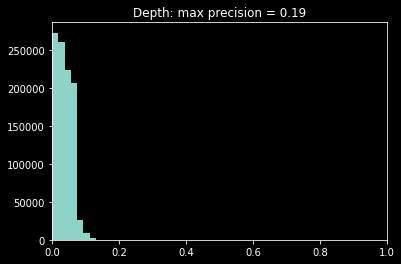

In [18]:
plt.hist(precision_random)
precision_max = '{0:.2f}'.format(max(precision_random))
plt.title('Depth: max precision = {}'.format(precision_max))
plt.xlim(0, 1)

In [81]:
metrics

{'accuracy': 0.9867957746478874,
 'precision': 0.9344262295081968,
 'recall': 0.6867469879518072,
 'f_score': 0.8715596330275229}

In [36]:
y_pred.sum()

73.0

In [53]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [55]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_data, y_train)
rf_random.best_params_

Fitting 4 folds for each of 100 candidates, totalling 400 fits


{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [56]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    cf_matrix = confusion_matrix(test_labels, predictions)
    metrics = get_metrics(cf_matrix)
    print('Model Performance')
    print('Precision: {:0.4f} '.format(metrics['precision']))
    print('Recall = {:0.2f}%.'.format(metrics['recall']))

    return metrics['precision'], metrics['recall']

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_data, y_train)
base_precision, base_recall = evaluate(base_model, X_test_data, y_test)

best_random = rf_random.best_estimator_
random_precision, random_recall = evaluate(best_random, X_test_data, y_test)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Precision: 0.8814 
Recall = 0.63%.
Model Performance
Precision: 0.8923 
Recall = 0.70%.


In [35]:
# LGBM tuning
from optuna.integration import LightGBMPruningCallback
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_train_data = X_train.iloc[:, 2:]
        selector = VarianceThreshold(.1)
        selector.fit_transform(X_train_data)
        X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
        X_test_data = X_test[X_train_data.columns]
        # X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        # y_train, y_test = y[train_idx], y[test_idx]

        model = LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train_data,
            y_train,
            eval_set=[(X_test_data, y_test)],
            eval_metric="average_precision",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )

        preds = model.predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, preds)
        metrics = get_metrics(cf_matrix)
        cv_scores[idx] = metrics['precision']
        print(metrics['precision'])

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, feat_all, y_all)
study.optimize(func, n_trials=20)

In [37]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.66436
	Best params:
		n_estimators: 10000
		learning_rate: 0.2566511597384914
		num_leaves: 1280
		max_depth: 8
		min_data_in_leaf: 2700
		lambda_l1: 15
		lambda_l2: 15
		min_gain_to_split: 2.2229313245452835
		bagging_fraction: 0.8
		bagging_freq: 1
		feature_fraction: 0.30000000000000004


In [32]:
# save final model
feat = feat_all.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(feat)
feat_data = feat[feat.columns[selector.get_support(indices=True)]]
# final_rf = RandomForestClassifier(n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=100, bootstrap=False).fit(feat_data, y_all)
final_rf = RandomForestClassifier().fit(feat_data, y_all)
# all_data_lgbm = LGBMClassifier().fit(feat_data, y_all)
joblib.dump(final_rf, 'rf_fast.pkl')
# joblib.dump(classifiers['Random Forest'], model_file)



['rf_fast.pkl']

In [33]:
# save final model
feat = feat_all.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(feat)
feat_data = feat[feat.columns[selector.get_support(indices=True)]]
final_rf = LGBMClassifier().fit(feat_data, y_all)
# all_data_lgbm = LGBMClassifier().fit(feat_data, y_all)
joblib.dump(final_rf, 'lgbm_fast.pkl')
# joblib.dump(classifiers['Random Forest'], model_file)

['lgbm_fast.pkl']

In [34]:
cols_df = feat_data.drop(feat_data[:].index)
cols_df.to_csv('features_fast.csv')

<BarContainer object of 40 artists>

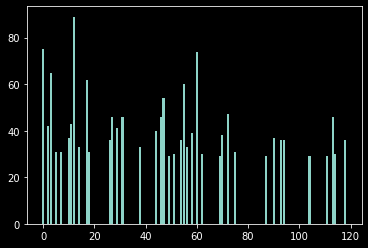

In [84]:
model = joblib.load('lgbm_fast.pkl')
imp = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp['imp'] = model.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(10)['imp'].values
plt.bar(imp.head(40).index, imp.head(40)['imp'].values)

In [86]:
imp.head(15)

,0,imp
12,std_cmin_norm,89
0,std,75
60,AH1-AH2_hcomp_cmin_norm,74
3,kurt,65
17,hcomp_cmin_norm,62
55,AH1-AH2_abspow,60
47,AH1-AH2_kurt,54
72,AH1-AH2_std_pmin_norm,47
27,abspow_cmin_norm,46
46,AH1-AH2_skew,46


In [87]:
model = joblib.load('rf_fast.pkl')
imp = pd.DataFrame(pd.read_csv('features_fast.csv').columns[1:])
imp['imp'] = model.feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
11,abspow,0.0661533788
55,AH1-AH2_abspow,0.0557266806
27,abspow_cmin_norm,0.0504857302
70,AH1-AH2_abspow_cmin_norm,0.0472651739
44,AH1-AH2_std,0.0457346700
56,AH1-AH2_std_cmin_norm,0.0449563788
0,std,0.0268306656
72,AH1-AH2_std_pmin_norm,0.0237104403
12,std_cmin_norm,0.0230879769
42,abspow_pmin_norm,0.0209006841


In [91]:
imp.head(15).iloc[:, 1].values

array([0.06615338, 0.05572668, 0.05048573, 0.04726517, 0.04573467,
       0.04495638, 0.02683067, 0.02371044, 0.02308798, 0.02090068,
       0.01956937, 0.019131  , 0.01828529, 0.01558636, 0.01527583])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

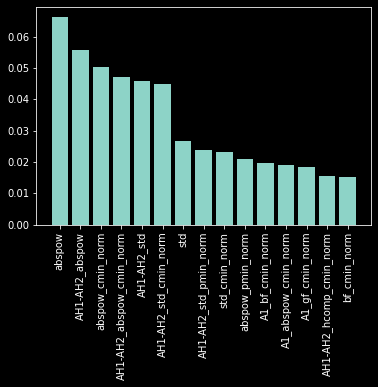

In [93]:
plt.bar(imp.head(15).iloc[:, 0], imp.head(15).iloc[:, 1])
plt.xticks(rotation='vertical')

Text(0, 0.5, 'Precision')

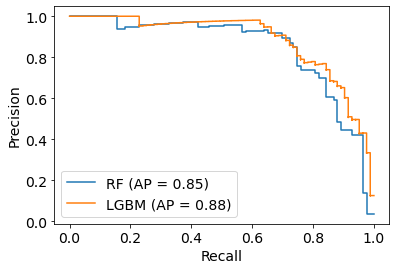

In [23]:
from sklearn.metrics import PrecisionRecallDisplay
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
model_rf = classifiers['Random Forest']
display = PrecisionRecallDisplay.from_estimator(
    model_rf, X_test_data, y_test, name="RF")
model_lgbm = classifiers['LGBM']
display = PrecisionRecallDisplay.from_estimator(
    model_lgbm, X_test_data, y_test, name="LGBM", ax = plt.gca())
plt.xlabel('Recall')
plt.ylabel('Precision')

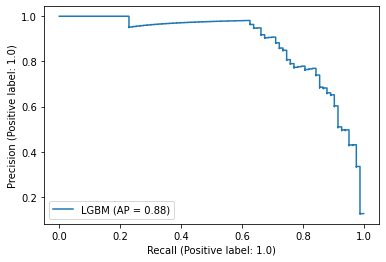

In [14]:
model = classifiers['LGBM']
display = PrecisionRecallDisplay.from_estimator(
    model, X_test_data, y_test, name="LGBM")

In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model_rf.predict_proba(X_test_data)[:, 1])

0.9768553666721682

In [25]:
roc_auc_score(y_test, model_lgbm.predict_proba(X_test_data)[:, 1])

0.9909225944875393

Logistic: f1=0.795 auc=0.850


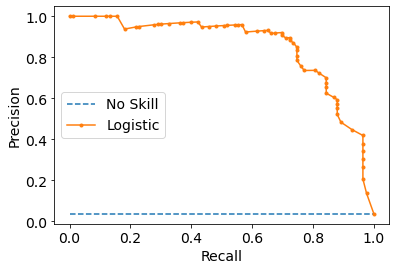

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
testX, testy = X_test_data, y_test
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(testy[testy==1]) / len(testy)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Logistic: f1=0.795 auc=0.881


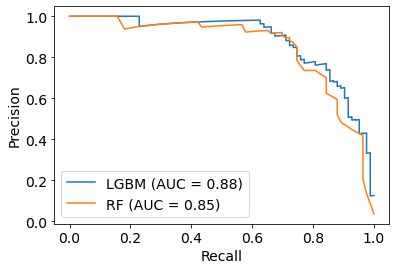

In [34]:
testX, testy = X_test_data, y_test
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='LGBM (AUC = 0.88)')
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, label='RF (AUC = 0.85)')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()